# 1. Подготовка

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [5]:
data.sort_index(inplace = True)
data.index.is_monotonic

True

In [6]:
data.isnull().sum()

num_orders    0
dtype: int64

In [7]:
data.duplicated().sum()

26415

Файл открыт и изучен. Данные цифровые: количество заказов в определенный момент времени. Пропусков нет, дубликаты(26415 шт.) допустимы при подобном типе данных. 

# 2. Анализ

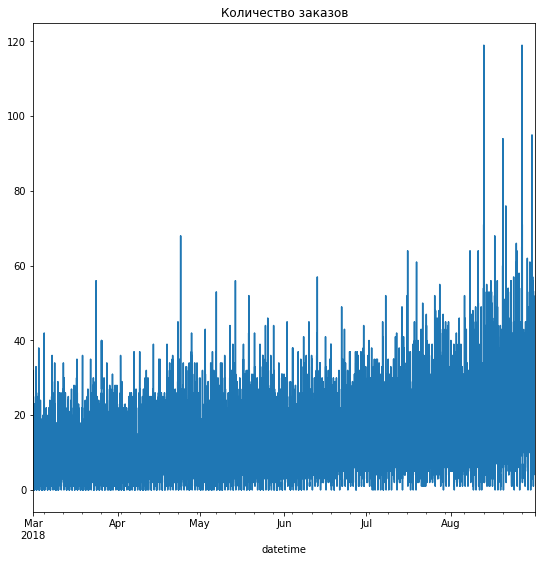

In [8]:
data['num_orders'].plot(title = "Количество заказов",figsize = (9,9))

In [9]:
#ресемплинг
data = data.resample('1H').sum()
#data.plot(figsize = (9,9),title = 'Количество заказов такси')

In [10]:
#декомпозиция
decomposed = seasonal_decompose(data)

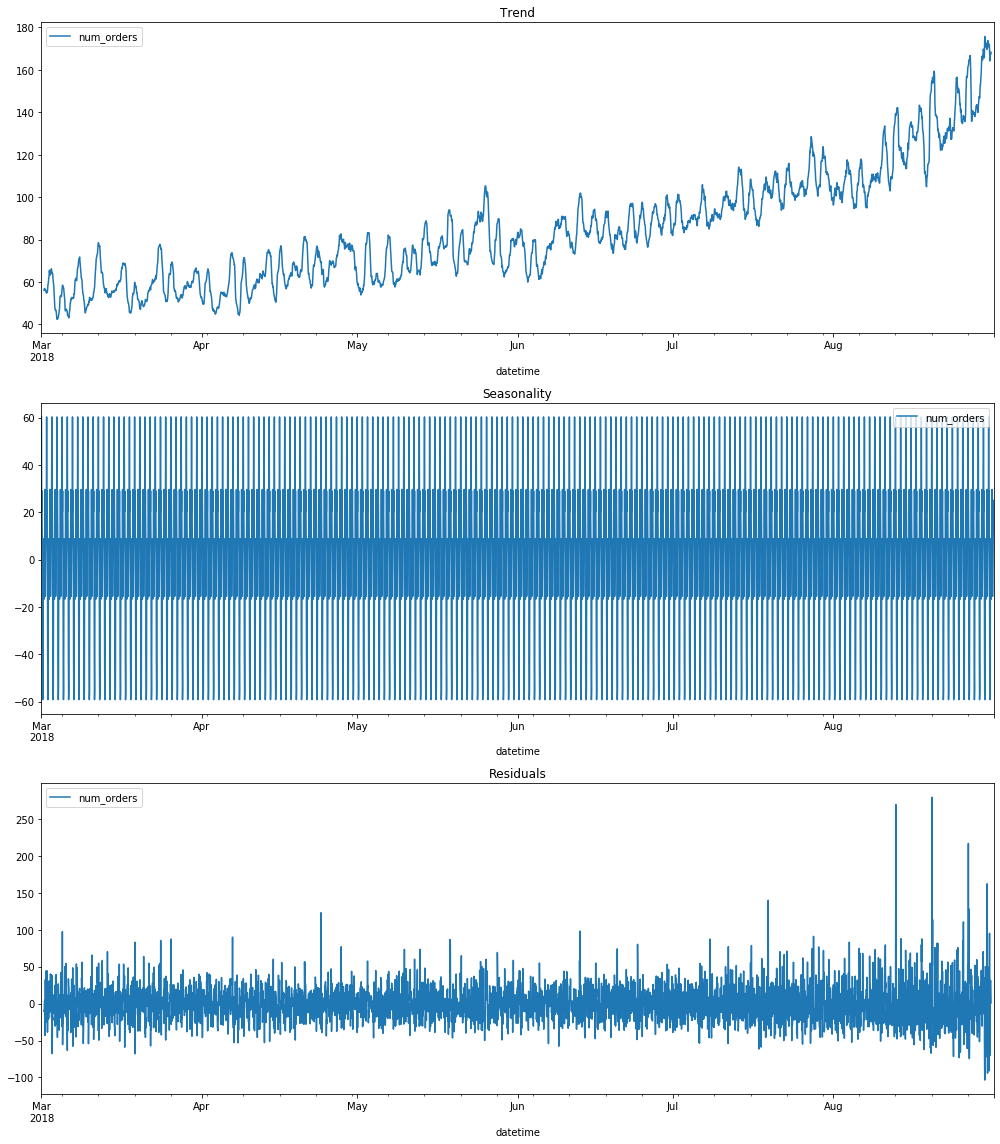

In [11]:
plt.figure(figsize=(14, 16))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax = plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax = plt.gca())
plt.title('Residuals')
plt.tight_layout()

В определенные моменты времени присутсвуют резкие скачки в данных, то есть есть "часы-пик", когда колиство заказов такси резко растет,так же заметен значительный рост в среднем количества заказов с увеличением времени. Из графика тренда видно, что присутствует плавное ежемесячное увеличение объема заказов такси.Проследить сезонность на полученных данных из-за из масштаба,так как данные представлены менее, чем за 1 год. 

# 3. Обучение

In [12]:
#создание признаков
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(data, 1,1)

Выбраны следующие факторы в модель: месяц,день недели,день,часБ,lag,rolling; количество заказов коррелируется не только по месяцам, но так же оно зависит от часа или же дня(разница заказов в будни и выходные дни),так же важно отследить лаги и скользящее среднее с наименьшим размером окна, для устранения сильного сглажвания результатов.

In [13]:
#деление на выборки
train, test = train_test_split(data, test_size = 0.1,shuffle = False)

In [14]:
train = train.dropna()
features_train = train.drop(['num_orders'],axis = 1)
target_train = train['num_orders']

In [15]:
features_test = test.drop(['num_orders'],axis = 1)
target_test = test['num_orders']

In [16]:
data.head(10)

,num_orders,month,day,dayofweek,hour,lag_1,rolling_mean
datetime,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,124.0
2018-03-01 02:00:00,71,3,1,3,2,85.0,85.0
2018-03-01 03:00:00,66,3,1,3,3,71.0,71.0
2018-03-01 04:00:00,43,3,1,3,4,66.0,66.0
2018-03-01 05:00:00,6,3,1,3,5,43.0,43.0
2018-03-01 06:00:00,12,3,1,3,6,6.0,6.0
2018-03-01 07:00:00,15,3,1,3,7,12.0,12.0
2018-03-01 08:00:00,34,3,1,3,8,15.0,15.0


In [17]:
#модель № 1
model = LinearRegression()
model.fit(features_train,target_train)
pred = model.predict(features_test)
print('RMSE:',round(mean_squared_error(target_test,pred)**0.5,4))

RMSE: 52.8253


In [18]:
#кросс-валидация модели № 1
cross_val_score(model,features_test,target_test,cv=5).mean()

0.1924196791998814

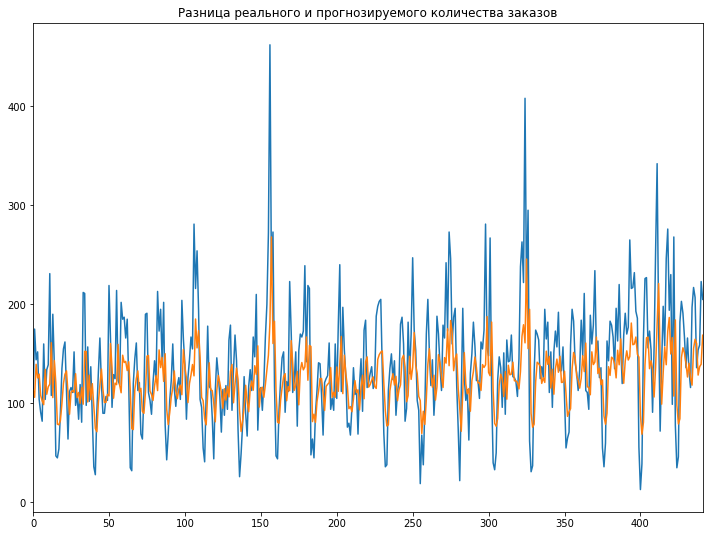

In [19]:
target_test.index = np.arange(len(target_test))
target_test.plot(title = "Разница реального и прогнозируемого количества заказов",figsize = (12,9))
pd.Series(pred).plot()

In [20]:
#модель № 2
model2_1 = CatBoostRegressor(depth = 10,learning_rate =0.1,iterations =50)
model2_1.fit(features_train,target_train)
prediction2_1 = model2_1.predict(features_test)
print('RMSE:', round(mean_squared_error(target_test,prediction2_1) ** 0.5,5))

model2_2 = CatBoostRegressor(depth = 11,learning_rate =0.5,iterations =100)
model2_2.fit(features_train,target_train)
prediction2_2 = model2_2.predict(features_test)
print('RMSE:', round(mean_squared_error(target_test,prediction2_2) ** 0.5,5))

model2_3 = CatBoostRegressor(depth = 12 ,learning_rate =0.8,iterations =150)
model2_3.fit(features_train,target_train)
prediction2_3 = model2_3.predict(features_test)
print('RMSE:', round(mean_squared_error(target_test,prediction2_3) ** 0.5,5))

0:	learn: 36.6181224	total: 59.5ms	remaining: 2.91s
1:	learn: 34.9692652	total: 65ms	remaining: 1.56s
2:	learn: 33.6291379	total: 72ms	remaining: 1.13s
3:	learn: 32.4564548	total: 78.9ms	remaining: 908ms
4:	learn: 31.3907784	total: 162ms	remaining: 1.46s
5:	learn: 30.4869582	total: 167ms	remaining: 1.22s
6:	learn: 29.6128527	total: 174ms	remaining: 1.07s
7:	learn: 28.8150224	total: 261ms	remaining: 1.37s
8:	learn: 28.1276261	total: 267ms	remaining: 1.21s
9:	learn: 27.6331290	total: 273ms	remaining: 1.09s
10:	learn: 27.0650311	total: 358ms	remaining: 1.27s
11:	learn: 26.6039308	total: 364ms	remaining: 1.15s
12:	learn: 26.0408449	total: 370ms	remaining: 1.05s
13:	learn: 25.6922544	total: 453ms	remaining: 1.16s
14:	learn: 25.2532471	total: 459ms	remaining: 1.07s
15:	learn: 24.9388498	total: 466ms	remaining: 990ms
16:	learn: 24.6452620	total: 550ms	remaining: 1.07s
17:	learn: 24.4493910	total: 557ms	remaining: 990ms
18:	learn: 24.2047459	total: 563ms	remaining: 918ms
19:	learn: 23.9797945	

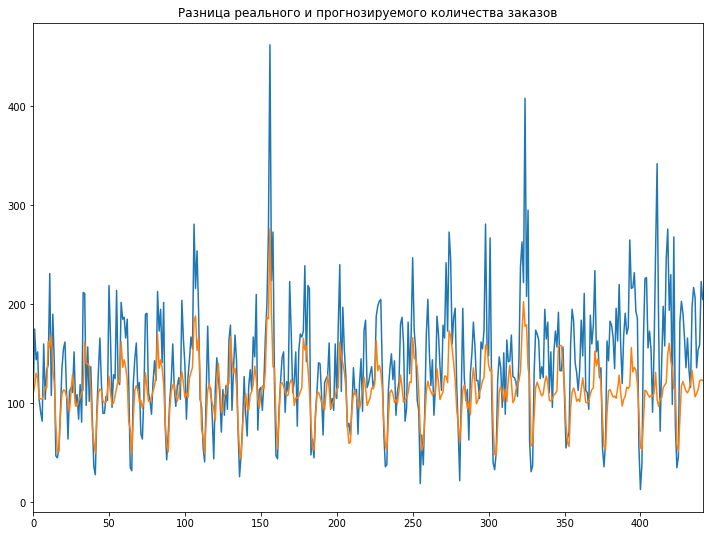

In [21]:
target_test.plot(title = "Разница реального и прогнозируемого количества заказов",figsize = (12,9))
pd.Series(prediction2_1).plot()

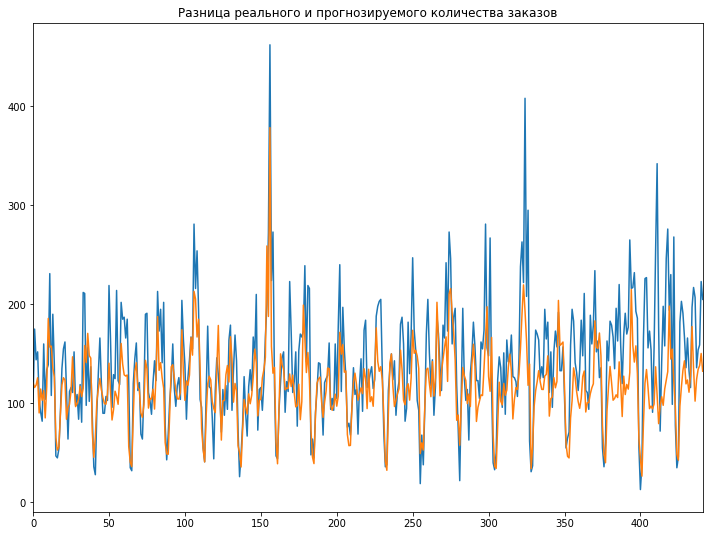

In [22]:
target_test.plot(title = "Разница реального и прогнозируемого количества заказов",figsize = (12,9))
pd.Series(prediction2_2).plot()

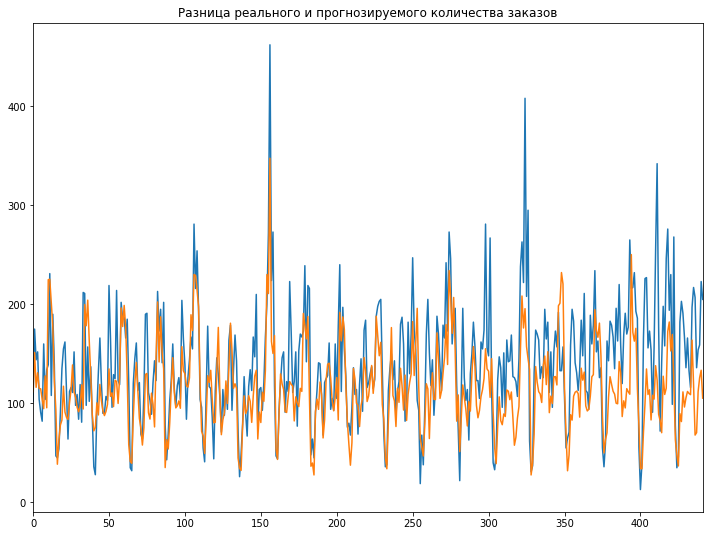

In [23]:
target_test.plot(title = "Разница реального и прогнозируемого количества заказов",figsize = (12,9))
pd.Series(prediction2_3).plot()

In [24]:
#кросс-валидация модели № 2
cross_val_score(model2_1,features_test,target_test,cv=5).mean()

0:	learn: 58.5095034	total: 9.29ms	remaining: 455ms
1:	learn: 56.5754773	total: 11.7ms	remaining: 282ms
2:	learn: 54.3032640	total: 13.2ms	remaining: 206ms
3:	learn: 52.7020194	total: 17.6ms	remaining: 202ms
4:	learn: 51.1543986	total: 18.2ms	remaining: 164ms
5:	learn: 49.7901834	total: 40.3ms	remaining: 296ms
6:	learn: 48.3123548	total: 44ms	remaining: 270ms
7:	learn: 46.9050804	total: 48.7ms	remaining: 256ms
8:	learn: 45.7151701	total: 53.2ms	remaining: 242ms
9:	learn: 44.8376041	total: 57.1ms	remaining: 228ms
10:	learn: 44.0150785	total: 136ms	remaining: 483ms
11:	learn: 43.2992648	total: 142ms	remaining: 448ms
12:	learn: 42.4949206	total: 146ms	remaining: 415ms
13:	learn: 41.8026297	total: 150ms	remaining: 386ms
14:	learn: 41.3468800	total: 151ms	remaining: 352ms
15:	learn: 40.5583579	total: 155ms	remaining: 330ms
16:	learn: 40.1004182	total: 235ms	remaining: 456ms
17:	learn: 39.5091349	total: 239ms	remaining: 425ms
18:	learn: 38.9857335	total: 242ms	remaining: 395ms
19:	learn: 38.

0.38719449851034665

In [25]:
cross_val_score(model2_2,features_test,target_test,cv=5).mean()

0:	learn: 51.3499189	total: 12.2ms	remaining: 1.21s
1:	learn: 44.5204140	total: 14ms	remaining: 687ms
2:	learn: 40.0158870	total: 15.8ms	remaining: 510ms
3:	learn: 37.3821573	total: 26.4ms	remaining: 634ms
4:	learn: 35.4262937	total: 38ms	remaining: 721ms
5:	learn: 34.1126904	total: 38.8ms	remaining: 609ms
6:	learn: 31.9009549	total: 47ms	remaining: 625ms
7:	learn: 30.3701884	total: 125ms	remaining: 1.44s
8:	learn: 28.9068596	total: 135ms	remaining: 1.37s
9:	learn: 27.3080573	total: 145ms	remaining: 1.31s
10:	learn: 26.6433695	total: 146ms	remaining: 1.18s
11:	learn: 25.1322160	total: 223ms	remaining: 1.64s
12:	learn: 24.1421829	total: 232ms	remaining: 1.55s
13:	learn: 22.9503764	total: 243ms	remaining: 1.49s
14:	learn: 21.7141926	total: 325ms	remaining: 1.84s
15:	learn: 20.7113293	total: 335ms	remaining: 1.76s
16:	learn: 19.1467753	total: 343ms	remaining: 1.68s
17:	learn: 18.5618948	total: 422ms	remaining: 1.92s
18:	learn: 17.4849165	total: 433ms	remaining: 1.85s
19:	learn: 16.9686005

0.3900593412567779

In [26]:
cross_val_score(model2_3,features_test,target_test,cv=5).mean()

0:	learn: 46.7885012	total: 21.3ms	remaining: 3.18s
1:	learn: 39.8165000	total: 70.2ms	remaining: 5.19s
2:	learn: 35.5483901	total: 70.8ms	remaining: 3.47s
3:	learn: 32.2501889	total: 85ms	remaining: 3.1s
4:	learn: 29.3997623	total: 176ms	remaining: 5.1s
5:	learn: 25.7030919	total: 269ms	remaining: 6.45s
6:	learn: 23.8764488	total: 285ms	remaining: 5.82s
7:	learn: 22.6199675	total: 368ms	remaining: 6.54s
8:	learn: 20.4680118	total: 455ms	remaining: 7.12s
9:	learn: 19.1709518	total: 470ms	remaining: 6.58s
10:	learn: 17.8821712	total: 560ms	remaining: 7.07s
11:	learn: 16.2590275	total: 574ms	remaining: 6.6s
12:	learn: 15.4137917	total: 655ms	remaining: 6.91s
13:	learn: 14.3776904	total: 677ms	remaining: 6.57s
14:	learn: 13.5487886	total: 769ms	remaining: 6.92s
15:	learn: 12.8090469	total: 860ms	remaining: 7.2s
16:	learn: 11.9216375	total: 878ms	remaining: 6.87s
17:	learn: 11.1917889	total: 965ms	remaining: 7.08s
18:	learn: 10.7510029	total: 1.05s	remaining: 7.26s
19:	learn: 9.7018965	tot

0.3449268248446778

In [27]:
#выбор значения гиперпараметра max_depth для модели № 3
max_depth_array = [1, 3, 5, 6, 7, 10, 15, 20, 25]
model3 = DecisionTreeRegressor()
grid = GridSearchCV(model3, param_grid={'max_depth': max_depth_array})
grid.fit(features_train,target_train)
best_max_depth = grid.best_estimator_.max_depth
print(grid.best_score_, best_max_depth)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.20350172799375577 7


In [28]:
#модель № 3
model3 = DecisionTreeRegressor(random_state = 123,max_depth = 5)
model3.fit(features_train,target_train)
prediction3 = model3.predict(features_test)
print('RMSE:', round(mean_squared_error(target_test,prediction3) ** 0.5,5))

RMSE: 57.20477


In [29]:
#кросс-валидация модели 3
cross_val_score(model3,features_test,target_test,cv=5).mean()

0.3221792402871094

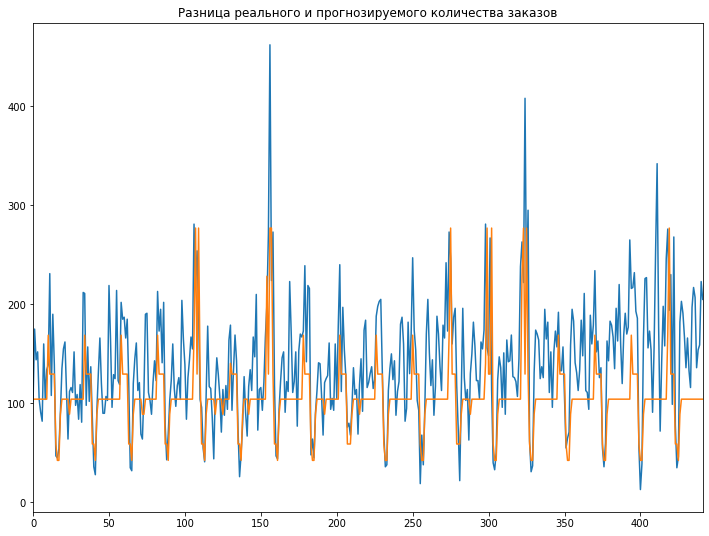

In [30]:
target_test.plot(title = "Разница реального и прогнозируемого количества заказов",figsize = (12,9))
pd.Series(prediction3).plot()

In [31]:
#выбор значения гиперпараметров для модели № 4
n_estimators_array = [1, 3, 5, 7, 10, 15]
max_depth_array = [1, 3, 5, 7, 10, 15,20,25]
model4 = RandomForestRegressor(random_state = 42)
grid = GridSearchCV(model4, param_grid=({'n_estimators': n_estimators_array},{'max_depth': max_depth_array}))
grid.fit(features_train,target_train)
best_max_depth = grid.best_estimator_.max_depth
best_n_estimators = grid.best_estimator_.n_estimators
print(grid.best_score_, best_n_estimators,best_max_depth)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245:

0.32047312685116774 15 None


In [32]:
model4 = RandomForestRegressor(random_state = 42,max_depth =7 ,n_estimators =10 )
model4.fit(features_train,target_train)
prediction4 = model4.predict(features_test)
print('RMSE:', round(mean_squared_error(target_test,prediction4) ** 0.5,5))

RMSE: 51.55971


In [33]:
#кросс-валидация модели 4
cross_val_score(model4,features_test,target_test,cv=5).mean()

0.5078733411188209

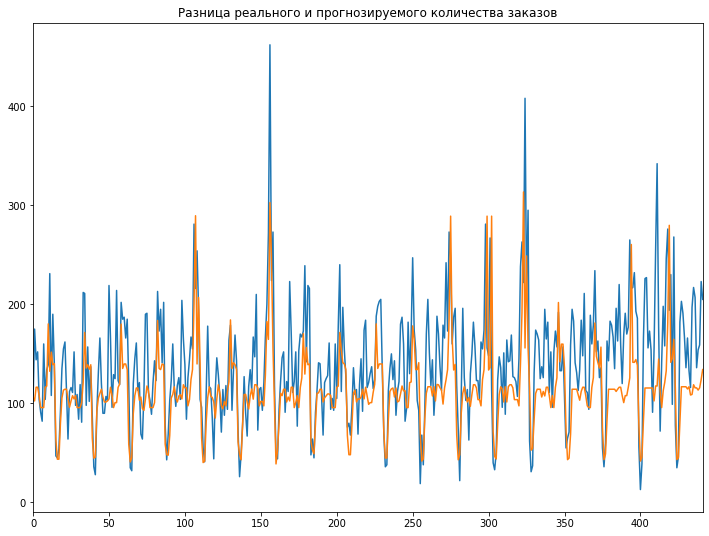

In [34]:
target_test.plot(title = "Разница реального и прогнозируемого количества заказов",figsize = (12,9))
pd.Series(prediction4).plot()

Модели обучены и по ним подсчитана метрика качества RMSE,так жк к каждой модели применена кросс-валидация. Наилучшей моделью по качеству является модель № 2_2,что наглядно видно на графиках разницы реального и прогнозируемого количества заказов,где модель № 2_2 в предсказаниях чаще всего попадает в реальные значения,однако есть расхождения в значениях, где присутствуют анамалии.


Метрика качества и кросс валидация каждой модели:


Модель № 1: 
RMSE: 52.8253
Кросс-валидация: 0.1924


Модель № 2_1:
RMSE: RMSE: 50.26863
Кросс-валидация:0.387194

<font color = blue>
Модель № 2_2:
RMSE: 46.312
Кросс-валидация:0.39005
</font> 

Модель № 2_3:
RMSE: 0.387194
Кросс-валидация:0.3449

Модель № 3:
RMSE: 57.20477
Кросс-валидация:0.32217

Модель № 4:
RMSE: 51.55971
Кросс-валидация:0.50787


# 4. Тестирование

In [35]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(features_train,target_train)
predictions = dummy_clf.predict(features_test)
print('RSME:',mean_squared_error(target_test, predictions) ** 0.5)

RSME: 88.64441651443998


Для проверки модели на адекватность был использован классификатор в качестве простой базовой линии для сравнения с реальными классификаторами. Проверка показала, что модель № 2_2 дает наилучший результат по используемой метрике, чем используемым для сравнения классификатор, тем самым доказывая адекватность модели.

RMSE модели:  46.312 

RMSE классификатора: 88.644

# Вывод

Файл открыт и изучен. Данные цифровые: количество заказов в определенный момент времени. Пропусков нет, дубликаты(3977 шт.) допустимы при подобном типе данных.

В определенные моменты времени присутсвуют резкие скачки в данных, то есть есть "часы-пик", когда колиство заказов такси резко растет,так же заметен значительный рост в среднем количества заказов с увеличением времени. Из графика тренда видно, что присутствует плавное ежемесячное увеличение объема заказов такси.Проследить сезонность на полученных данных из-за из масштаба,так как данные представлены менее, чем за 1 год. 

Модели обучены и по ним подсчитана метрика качества RMSE,так жк к каждой модели применена кросс-валидация. Наилучшей моделью по качеству является модель № 1,что наглядно видно на графиках разницы реального и прогнозируемого количества заказов.


Метрика качества и кросс валидация каждой модели:

Модель № 1: RMSE: 52.8253 Кросс-валидация: 0.1924

Модель № 2_1: RMSE: RMSE: 50.26863 Кросс-валидация:0.387194

Модель № 2_2: RMSE: 46.312 Кросс-валидация:0.39005
Модель № 2_3: RMSE: 0.387194 Кросс-валидация:0.3449

Модель № 3: RMSE: 57.20477 Кросс-валидация:0.32217

Модель № 4: RMSE: 51.55971 Кросс-валидация:0.50787

Для проверки модели на адекватность был использован классификатор в качестве простой базовой линии для сравнения с реальными классификаторами. Проверка показала, что модель № 2_2 дает наилучший результат по используемой метрике, чем используемым для сравнения классификатор, тем самым доказывая адекватность модели.


RMSE модели:  46.312 

RMSE классификатора: 88.644